# Automatic-counting-of-epidermal-cells-with-Deep-Learning

## Librerias

In [4]:
from detectron2.utils.logger import setup_logger
logger = setup_logger()
from detectron2.data.datasets import register_coco_instances

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import CfgNode as CN

from tqdm import tqdm
import os
import torch
from torch.utils.data import Dataset, DataLoader
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle
import matplotlib.pyplot as plt
import random
import cv2
import torch

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [6]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-_hqiwsx8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-_hqiwsx8
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Configuración de un conjunto de datos para su uso en el framework Detectron2

In [7]:
# Some configurations
name_ds = "dataset"
name_ds_train = name_ds + "_train"
name_ds_val = name_ds + "_val"
name_ds_test = name_ds + "_test"
image_root_train = name_ds + "/train"
image_root_validation = name_ds + "/validation"
image_root_test = name_ds + "/test"

json_file_train = name_ds + "/train/" + 'coco_annotation_train.json'
json_file_val = name_ds + "/validation/" + 'coco_annotation_validation.json'
json_file_test = name_ds + "/test/" + 'coco_annotation_test.json'

# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )

## validation dataset
register_coco_instances(
    name = name_ds_val,
    metadata = {},
    json_file = json_file_val,
    image_root = image_root_validation
    )

## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )


In [8]:
train_metadata = MetadataCatalog.get(name_ds_train)
train_dataset_dicts = DatasetCatalog.get(name_ds_train)

[11/18 18:34:16 d2.data.datasets.coco]: Loaded 54 images in COCO format from dataset/train/coco_annotation_train.json


In [9]:
val_metadata = MetadataCatalog.get(name_ds_val)
val_dataset_dicts = DatasetCatalog.get(name_ds_val)

[11/18 18:34:42 d2.data.datasets.coco]: Loaded 6 images in COCO format from dataset/validation/coco_annotation_validation.json


In [10]:
test_metadata = MetadataCatalog.get(name_ds_test)
test_dataset_dicts = DatasetCatalog.get(name_ds_test)

[11/18 18:34:57 d2.data.datasets.coco]: Loaded 8 images in COCO format from dataset/test/coco_annotation_test.json


### Visualizar ejemplo

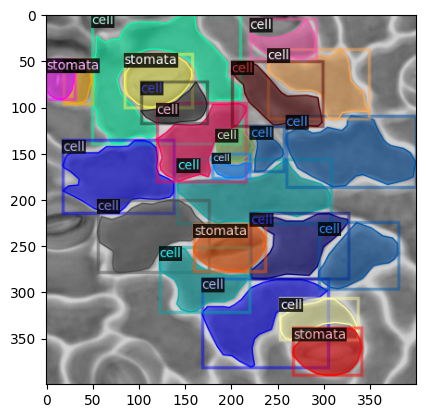

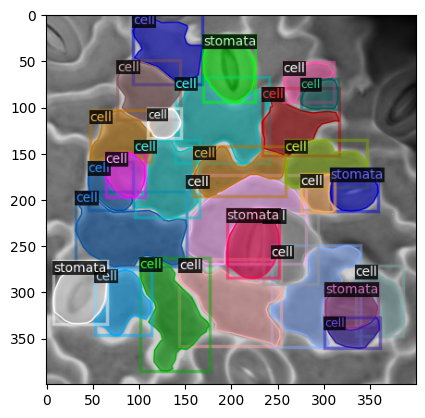

In [14]:
for d in random.sample(train_dataset_dicts,2):
    img = cv2.imread(d['file_name'])
    visualizer = Visualizer(img[:,:,::-1], metadata= train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:,:,::-1])
    plt.show()

## Setting anchor sizes,anchor ratios and model

In [18]:
# Basic Option

#config_file_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
#checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"     


In [19]:
# Output directory
output_dir = "ResultadosEntrenamiento"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")

# Number of classes
nc = 3

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Select a larger model
config_file_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"


https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md

In [22]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Crear una configuración
cfg = get_cfg()

# Configurar el archivo de configuración del modelo y los pesos
config_file_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)

# Configurar el conjunto de datos de entrenamiento
cfg.DATASETS.TRAIN = (name_ds_train,)

# Configurar el número de trabajadores de carga de datos
cfg.DATALOADER.NUM_WORKERS = 2

# Configurar el número de imágenes por lote (batch size)
cfg.SOLVER.IMS_PER_BATCH = 4  # Puedes ajustar este valor según la capacidad de tu GPU

# Configurar la tasa de aprendizaje
cfg.SOLVER.BASE_LR = 0.00025

# Configurar el número máximo de iteraciones (epochs)
cfg.SOLVER.MAX_ITER = 5000

# Configurar el período para ajustar la tasa de aprendizaje
cfg.SOLVER.STEPS = (1000, 2000, 3000, 4000)  # Puedes ajustar estos valores según tu preferencia
cfg.SOLVER.GAMMA = 0.1  # Factor de reducción de la tasa de aprendizaje en cada paso

# Configurar el período para guardar puntos de control durante el entrenamiento
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

# Configurar el período para la evaluación durante el entrenamiento
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD

# Configurar el número de clases
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc

# Configurar el dispositivo de entrenamiento
cfg.MODEL.DEVICE = device

# Configurar el directorio de salida
cfg.OUTPUT_DIR = output_dir


### Trainer

In [23]:
trainer = DefaultTrainer(cfg)

[11/18 19:23:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

### AnchorCalculator, anchorSizeRatioTuner

In [24]:
print("MIN_SIZE_TRAIN", cfg.INPUT.MIN_SIZE_TRAIN)
print("MAX_SIZE_TRAIN", cfg.INPUT.MAX_SIZE_TRAIN)

MIN_SIZE_TRAIN (640, 672, 704, 736, 768, 800)
MAX_SIZE_TRAIN 1333


In [27]:
from hyperparameter_tuning import AnchorCalculator, anchorSizeRatioTuner

anchorcalcualtor = AnchorCalculator(trainer,cfg)

data = anchorcalcualtor.data
for i in data:
  print(i['image'].shape)


torch.Size([3, 672, 672])
torch.Size([3, 672, 672])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])


In [28]:
images = trainer.model.preprocess_image(data)
print(images.tensor.shape)

torch.Size([4, 3, 768, 768])


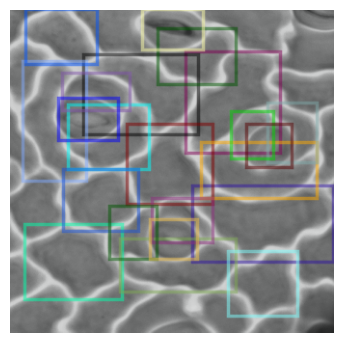

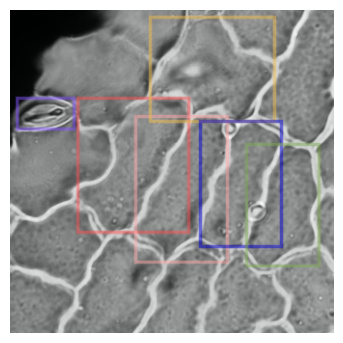

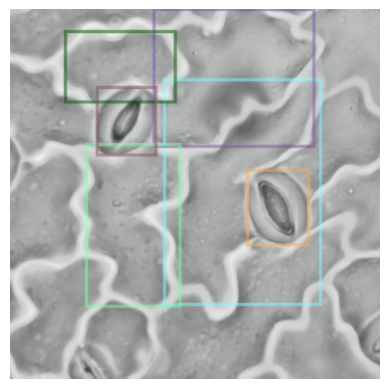

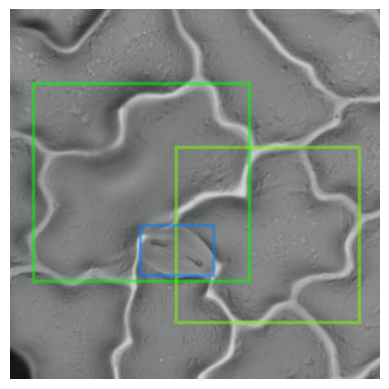

In [29]:
anchorcalcualtor.visualize_images_gt_box()

In [30]:
gt_boxes = anchorcalcualtor.get_gt_boxes(1000)
print()
print(gt_boxes.shape)

100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 195511.30it/s]


torch.Size([37000, 4])


In [31]:
gt_wh = anchorcalcualtor.boxes2wh()
print(gt_wh.min(), gt_wh.max())

tensor(64.) tensor(465.)


In [32]:
print("sizes", cfg.MODEL.ANCHOR_GENERATOR.SIZES)
print("ratios", cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS)

sizes [[32], [64], [128], [256], [512]]
ratios [[0.5, 1.0, 2.0]]


In [33]:
print("recall", anchorcalcualtor.best_recall())
print("fitness", anchorcalcualtor.fitness())

recall tensor(1.)
fitness tensor(0.7613)


#### Using clstering

In [35]:
gt_sizes = anchorcalcualtor.wh2size()
gt_ratios = anchorcalcualtor.wh2ratio()

In [36]:
anchorTuner = anchorSizeRatioTuner(trainer, fit_fn = anchorcalcualtor.fitness)

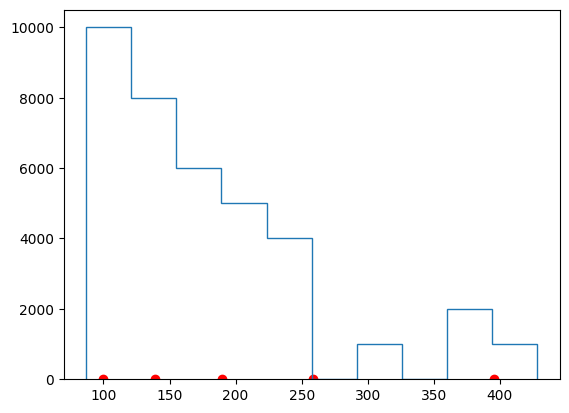

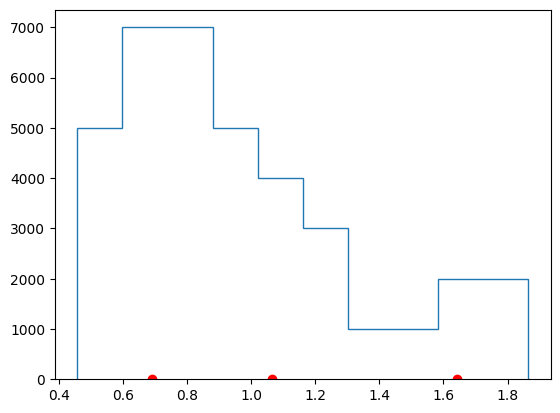

In [37]:
sizes = anchorTuner.estimate_clusters(gt_sizes, 5)
anchorTuner.visualize_clusters(gt_sizes, sizes)
ratios = anchorTuner.estimate_clusters(gt_ratios, 3)
anchorTuner.visualize_clusters(gt_ratios, ratios)

In [38]:
anchors = trainer.model.proposal_generator.anchor_generator.generate_cell_anchors
anchors = anchors(sizes, ratios)

In [39]:
anchorcalcualtor.fitness(anchors = anchors)

tensor(0.8805, dtype=torch.float64)

In [40]:
print("sizes", sizes)
print("ratios", ratios)

sizes [258.47983 190.07063 139.31676  99.71051 395.71606]
ratios [1.0646099  0.69088644 1.6436219 ]


### Evolve the results using the genetic algorithm

In [41]:
e_sizes, e_ratios = anchorTuner.evolve(sizes, ratios)

Evolving ratios and sizes, Fitness = 0.8853: 100%|█| 10000/10000 [02:19<00:00, 7


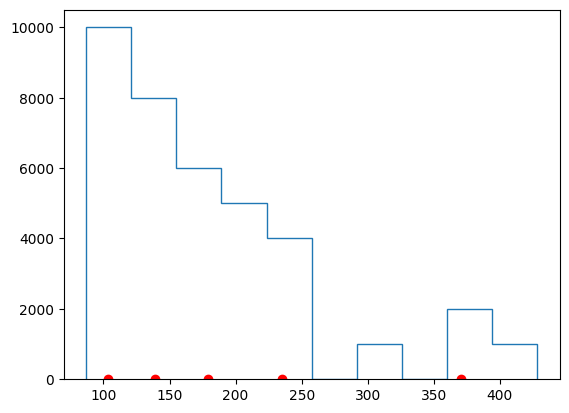

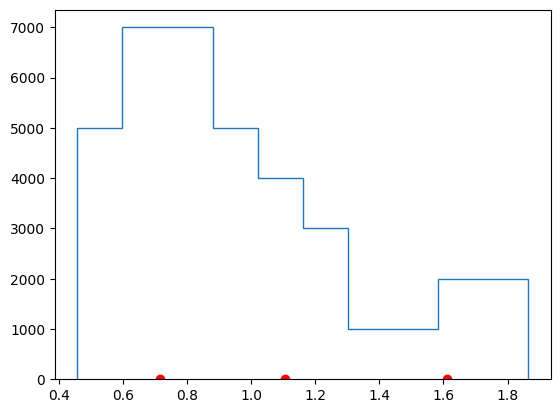

In [42]:
anchorTuner.visualize_clusters(gt_sizes, e_sizes)
anchorTuner.visualize_clusters(gt_ratios, e_ratios)

In [43]:
print("sizes", e_sizes)
print("ratios", e_ratios)

sizes [235.22549476 179.05405228 139.30770719 103.55499222 370.6310331 ]
ratios [1.10595414 0.71510455 1.61066097]


### Pixel means and Standar deviations

In [46]:
#!pip install albumentations

In [50]:
from hyperparameter_tuning import ImagesMeanStd
from dataset_utils import DatasetWithTransform
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json

#### Batch

In [51]:
batch_size = 32
num_workers = 2
image_size = 800
augs = A.Compose([
    A.Resize(height = image_size, width = image_size),
    ToTensorV2()])

In [52]:
with open(json_file_train) as f:
  ds = json.load(f)['images']

tds = DatasetWithTransform(ds, img_dir=image_root_train, transform=augs)
image_loader = DataLoader(tds, 
                          batch_size  = batch_size, 
                          shuffle     = False, 
                          num_workers = num_workers,
                          pin_memory  = True)

### Obtain pixels mean and std

In [53]:
ims = ImagesMeanStd()

for inputs in tqdm(image_loader):
    ims.push(inputs)

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s]


In [54]:
print(ims.mean)
print(ims.std)

tensor([141.4449, 141.4449, 141.4449])
tensor([34.6302, 34.6302, 34.6302])


## Train configuration

In [55]:
# Output directory
output_dir = "ResultadosEntrenamientoModel"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")

# Number of classes
nc = 3

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Select a larger model
config_file_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"


# cgf

In [ ]:
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_file_url)

cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST = (name_ds_val,)

cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.STEPS = [1000, 2000]  # Adjust these values
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.WARMUP_ITERS = 600
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.NESTROV = False

cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[30.45273822], [53.85942469], [15.13167065], [191.34330203], [92.40725238]] 
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[6.10302012, 0.75262411, 1.20024607]] 

cfg.MODEL.PIXEL_MEAN = [119.5349, 133.1262, 134.5580]
cfg.MODEL.PIXEL_STD = [42.3578, 43.1707, 43.8291]

cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc

cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir


In [ ]:
# save configuration file for future use
with open(output_cfg_path, "wb") as f:
  pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)

# Train()

In [ ]:
import gc
gc.collect()

In [ ]:
from model import *

In [ ]:
trainer = EagleNestTrainer(cfg)
bm_hook = BestModelHook(cfg, 
                        metric  = "segm/AP50", 
                        min_max = "max")
trainer.register_hooks(hooks=[bm_hook])